In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import os

In [2]:
# --- 1. 配置参数 ---
MODEL_NAME = "uer/gpt2-chinese-cluecorpussmall"
DATA_PATH = r"D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv" # 使用原始字符串防止转义问题
TEXT_COLUMN = "review_content"
LABEL_COLUMN = "sentiment"
NUM_LABELS = 2 # 情感标签数量 (例如 0: 负面, 1: 正面)
TEST_SIZE = 0.2 # 测试集比例
OUTPUT_DIR = "./results" # 模型检查点和日志的输出目录
LOGGING_DIR = "./logs"   # TensorBoard 日志目录
TRAIN_BATCH_SIZE = 16    # 根据你的 GPU 显存调整
EVAL_BATCH_SIZE = 32     # 根据你的 GPU 显存调整
NUM_EPOCHS = 1           # 训练轮数，可以先设为1快速查看效果，后续增加
LEARNING_RATE = 2e-5
SEED = 42                # 随机种子，保证可复现性

In [3]:
# --- 2. 检查 GPU ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"使用 GPU: {torch.cuda.get_device_name(0)}")
    # 获取可用显存并打印（可选）
    total_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU 总显存: {total_mem:.2f} GB")
else:
    device = torch.device("cpu")
    print("使用 CPU")

使用 GPU: NVIDIA GeForce RTX 4070 SUPER
GPU 总显存: 11.99 GB


In [4]:
# --- 3. 加载和准备数据 ---
print(f"正在从 {DATA_PATH} 加载数据...")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"数据加载成功，总共 {len(df)} 条记录。")
    print("数据预览:")
    print(df.head())

    # 选择需要的列并重命名 (transformers 期望 'text' 和 'label')
    df = df[[TEXT_COLUMN, LABEL_COLUMN]].copy()
    df.rename(columns={TEXT_COLUMN: 'text', LABEL_COLUMN: 'label'}, inplace=True)

    # 检查标签分布
    print("\n标签分布:")
    print(df['label'].value_counts())

    # 确保标签是整数类型
    df['label'] = df['label'].astype(int)

    # 移除包含 NaN 的行 (特别是文本列)
    df.dropna(subset=['text', 'label'], inplace=True)
    df = df[df['text'].apply(lambda x: isinstance(x, str))] # 确保文本是字符串
    print(f"移除缺失值后，剩余 {len(df)} 条记录。")

    # 划分训练集和测试集
    train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=SEED, stratify=df['label'])
    print(f"\n训练集大小: {len(train_df)}")
    print(f"测试集大小: {len(test_df)}")

    # 转换为 Hugging Face Datasets 格式
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'test': test_dataset
    })
    print("\n数据集已转换为 Hugging Face Datasets 格式:")
    print(dataset_dict)

except FileNotFoundError:
    print(f"错误：找不到数据文件 {DATA_PATH}")
    exit()
except Exception as e:
    print(f"加载或处理数据时出错: {e}")
    exit()

正在从 D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv 加载数据...
数据加载成功，总共 39985 条记录。
数据预览:
     user_id       username  rating                 review_content  likes  \
0  696432312            。。。       5            可以体验一下，剧情不错，但可能会有点迷      0   
1  679295528           云淡风轻       5                           剧情很好      0   
2  700357357        qqqqq美女       5  刺激，感受到了友情，亲情，自我，爱慕，传承，等待 ，与纯真      1   
3  402380140  User402380140       5            毋庸置疑的神作 第一次回溯时间的是葵啊      2   
4  434114561           不忆往事       5                   没有别的可以说，剧情神作      1   

          publish_time       device_model         game_name  sentiment  
0  2025-04-05 20:13:00        OPPO K7x中国版  7_years_from_now          1  
1  2025-04-05 17:35:00   Honor Play 40 5G  7_years_from_now          1  
2  2025-04-04 22:59:00        OPPO PGGM10  7_years_from_now          1  
3  2025-04-03 09:48:00  Redmi Note 10 Pro  7_years_from_now          1  
4  2025-04-03 01:08:00        Vivo V2148A 

In [5]:
# --- 4. 加载 Tokenizer 和模型 ---
print(f"\n正在加载 Tokenizer 和模型: {MODEL_NAME}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    # GPT2 默认没有 pad token，需要设置一个
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        print("Tokenizer 没有 pad_token, 已设置为 eos_token。")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        # 告知模型 pad_token_id，以便在计算损失时忽略填充部分
        pad_token_id=tokenizer.pad_token_id
    )
    # 确保模型配置的 pad_token_id 与 tokenizer 一致
    model.config.pad_token_id = tokenizer.pad_token_id

    print("Tokenizer 和模型加载成功。")
except Exception as e:
    print(f"加载 Tokenizer 或模型时出错: {e}")
    exit()


正在加载 Tokenizer 和模型: uer/gpt2-chinese-cluecorpussmall...


tokenizer_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wjw20\.cache\huggingface\hub\models--uer--gpt2-chinese-cluecorpussmall. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/421M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at uer/gpt2-chinese-cluecorpussmall and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer 和模型加载成功。


model.safetensors:   0%|          | 0.00/421M [00:00<?, ?B/s]

In [6]:
# --- 5. 数据预处理 (Tokenization) ---
def tokenize_function(examples):
    # padding='max_length' 会将所有序列填充到模型最大长度，可能较慢且占用显存
    # truncation=True 确保超过最大长度的序列被截断
    # max_length 可以根据需要设置，或者不设置让其使用模型默认最大长度
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

print("\n正在对数据集进行 Tokenize...")
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
print("Tokenize 完成。")

# 移除原始文本列，只保留模型需要的输入
tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"]) # 移除pandas转换时可能产生的索引列
tokenized_datasets.set_format("torch") # 设置格式为 PyTorch tensors


正在对数据集进行 Tokenize...


Map:   0%|          | 0/31988 [00:00<?, ? examples/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Tokenize 完成。


In [7]:
# --- 6. 定义评估指标 ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted') # 使用 weighted 考虑类别不平衡
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [9]:
# --- 7. 配置训练参数 ---
print("\n配置训练参数...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,                  # 输出目录
    num_train_epochs=NUM_EPOCHS,            # 训练轮数
    per_device_train_batch_size=TRAIN_BATCH_SIZE, # 训练批次大小
    per_device_eval_batch_size=EVAL_BATCH_SIZE,   # 评估批次大小
    learning_rate=LEARNING_RATE,            # 学习率
    warmup_steps=500,                       # 预热步数
    weight_decay=0.01,                      # 权重衰减
    logging_dir=LOGGING_DIR,                # 日志目录
    logging_steps=100,                      # 每 N 步记录一次日志
    eval_strategy="epoch",            # 每个 epoch 结束后进行评估
    save_strategy="epoch",                  # 每个 epoch 结束后保存模型
    load_best_model_at_end=True,            # 训练结束后加载最佳模型
    metric_for_best_model="accuracy",       # 使用准确率作为最佳模型指标
    greater_is_better=True,                 # 指标值越大越好
    seed=SEED,                              # 随机种子
    fp16=torch.cuda.is_available(),         # 如果有 GPU，启用混合精度训练 (可能需要安装 apex)
    report_to="tensorboard",                # 将日志报告给 TensorBoard
    # push_to_hub=False,                    # 不推送到 Hugging Face Hub
)


配置训练参数...


In [11]:
# --- 8. 初始化 Trainer ---
trainer = Trainer(
    model=model,                         # 预训练模型
    args=training_args,                  # 训练参数
    train_dataset=tokenized_datasets["train"], # 训练数据集
    eval_dataset=tokenized_datasets["test"],  # 评估数据集 (这里暂时用 test 代替 validation)
    compute_metrics=compute_metrics,     # 评估指标计算函数
    tokenizer=tokenizer,                 # Tokenizer (可选，用于数据整理)
)

C:\Users\wjw20\AppData\Local\Temp\ipykernel_21476\3130012700.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
# --- 9. 开始训练 ---
print("\n开始训练...")
try:
    train_result = trainer.train()
    print("训练完成。")
    # 打印训练摘要
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state() # 保存训练状态
    trainer.save_model(os.path.join(OUTPUT_DIR, "best_model")) # 保存最好的模型
except Exception as e:
    print(f"训练过程中发生错误: {e}")
    # 如果训练中断，尝试加载之前保存的最佳模型（如果存在）
    try:
        print("尝试加载之前可能保存的最佳模型...")
        model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR)
        tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)
        trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer) # 重新初始化 Trainer，仅用于预测
        print("成功加载模型，将进行评估。")
    except Exception as load_err:
        print(f"加载模型失败: {load_err}")
        print("无法继续评估。")
        exit()


开始训练...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.355200,0.367976,0.831687,0.829941,0.829474,0.831687


训练完成。
***** train metrics *****
  epoch                    =        1.0
  total_flos               =  7784329GF
  train_loss               =     0.4152
  train_runtime            = 0:10:40.06
  train_samples_per_second =     49.976
  train_steps_per_second   =      3.125



在测试集上进行最终评估...


评估完成。
测试集评估结果:
***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.8317
  eval_f1                 =     0.8299
  eval_loss               =      0.368
  eval_precision          =     0.8295
  eval_recall             =     0.8317
  eval_runtime            = 0:00:48.97
  eval_samples_per_second =    163.285
  eval_steps_per_second   =      5.105

获取测试集预测结果...

生成分类报告:
              precision    recall  f1-score   support

     Class 0       0.77      0.71      0.74      2726
     Class 1       0.86      0.89      0.87      5271

    accuracy                           0.83      7997
   macro avg       0.82      0.80      0.81      7997
weighted avg       0.83      0.83      0.83      7997


生成混淆矩阵:
[[1947  779]
 [ 567 4704]]
混淆矩阵图像已保存至: ./results\confusion_matrix.png

任务完成。


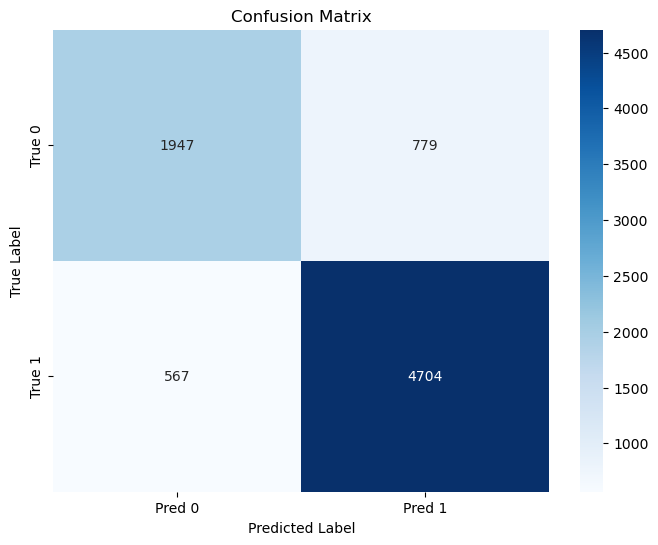

In [14]:
# --- 10. 在测试集上评估 ---
print("\n在测试集上进行最终评估...")
try:
    eval_metrics = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
    print("评估完成。")
    print("测试集评估结果:")
    trainer.log_metrics("eval", eval_metrics)
    trainer.save_metrics("eval", eval_metrics)

    # 获取预测结果
    print("\n获取测试集预测结果...")
    predictions = trainer.predict(tokenized_datasets["test"])
    predicted_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # --- 11. 生成评估报告和混淆矩阵 ---
    print("\n生成分类报告:")
    report = classification_report(true_labels, predicted_labels, target_names=[f'Class {i}' for i in range(NUM_LABELS)])
    print(report)

    print("\n生成混淆矩阵:")
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Pred {i}' for i in range(NUM_LABELS)], yticklabels=[f'True {i}' for i in range(NUM_LABELS)])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
    print(f"混淆矩阵图像已保存至: {os.path.join(OUTPUT_DIR, 'confusion_matrix.png')}")
    # plt.show() # 如果在交互式环境可以取消注释显示图像

except Exception as e:
    print(f"评估或生成报告时出错: {e}")

print("\n任务完成。")